Author: Eric Ballam

Date: 11/24/2021

### Overview
In this notebook we will be working on predicting when access to care will return to normal. For this we must know what normal means, according to the CDC on average 8% of Americans delay or do not get care so that will be our target number. We will also only be prediction the national average as the CDC didn't provide average access to care data for the other subgroup, so the subgroup United States will be our label. 

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import pandas as pd
import datetime
import matplotlib.pyplot as plt

from scipy.stats import pearsonr
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.metrics import mean_squared_error
from numpy import log

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Loading in data and converting dates to datetime objects

month = 'MAR'

df = pd.read_csv(f"DATA/DATAFRAME_{month}_accessToCare.csv")
df.loc[:,'Time Period Start Date'] = df['Time Period Start Date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d').date()) 
df.loc[:,'Time Period End Date'] = df['Time Period End Date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d').date())

df.head()

,Subgroup,Phase,Time Period,Time Period Start Date,Time Period End Date,Value,Low CI,High CI
0,United States,1,1,2020-04-23,2020-05-05,43.7,43.1,44.3
1,18 - 29 years,1,1,2020-04-23,2020-05-05,40.8,38.3,43.4
2,30 - 39 years,1,1,2020-04-23,2020-05-05,41.8,40.1,43.5
3,40 - 49 years,1,1,2020-04-23,2020-05-05,45.6,44.0,47.2
4,50 - 59 years,1,1,2020-04-23,2020-05-05,46.0,44.5,47.5


#### Correlation 
When working on our visulaizations it was clear that the data was heavly correlated. Many of the subgroups tracked very closely with our label of the United States. Before we can begin modeling we must identify and remove the heavily correlated features to prevent out model from becoming overfit. 

In [3]:
# Reshaping the data to make it easier to work to check for correlations

data = df.groupby(['Subgroup', 'Time Period']).mean()
data.head()

Phase  Value  Low CI  High CI
Subgroup      Time Period                               
18 - 29 years 1                1   40.8    38.3     43.4
              2                1   43.4    39.3     47.6
              3                1   41.0    38.9     43.2
              4                1   38.5    36.4     40.7
              5                1   39.6    37.2     42.1

In [4]:
# Using Pearsons R between the United States and the other subgroups shows us that many of the subgroups are heavily correlated with our label

c = []

for i in df.Subgroup.unique():
    corr, _ = pearsonr(data.loc['United States'].Value, data.loc[i].Value)
    c.append(corr)
pd.DataFrame(c, index = df.Subgroup.unique(), columns = ['corr']).head(20)

,corr
United States,1.000000
18 - 29 years,0.763270
30 - 39 years,0.933244
40 - 49 years,0.978078
50 - 59 years,0.983449
60 - 69 years,0.981236
70 - 79 years,0.956387
80 years and above,0.868199
Male,0.993919
Female,0.996014


In [5]:
# For this analysis we will remove any subgroup that is more then 70% correlated with the label, this left only 8 features to train on. 

labels = pd.DataFrame(c, index = df.Subgroup.unique())
labels.columns = ['corr']
labels = ['United States'] + list(labels[labels['corr'] <= 0.7].index)
labels

['United States',
 'Hispanic or Latino',
 'Non-Hispanic Asian, single race',
 'Less than a high school diploma',
 'District of Columbia',
 'Hawaii',
 'New Mexico',
 'West Virginia']

#### Modeling 
For this probject we clearly have time series multivariate data, thus we will use a vector autoregression model. From our visulaization we can see that our data doesn't have an seasional components so we can proceed without needing to check or correct for that. 

In [6]:
# Reshaping the data to make it easier to model with

row = []
for i in df.Subgroup.unique():
    row.append(list(data.loc[i].Value))
dfM = pd.DataFrame(row).T
dfM.columns = df.Subgroup.unique()

# Setting up training data
train = dfM[:-5]
train.columns = df.Subgroup.unique()
train = train[labels]

# Setting up validation data
val = dfM[-5:]
val.columns = df.Subgroup.unique()
val = val[labels]
# val

In [7]:
# Checking lag factors between 1 and 8

results = []

for i in range(1,9):
    
    # set up model     
    model = VAR(train)
    model_fit = model.fit(maxlags = i)
    
    # make prediction
    yhat = model_fit.forecast(model_fit.y, steps=5)
    
    # converting the results into a dataframe
    pred = pd.DataFrame(index=range(0,len(yhat)),columns=[labels])
    for j in range(0,len(labels)):
        for i in range(0, 5):
           pred.iloc[i][j] = yhat[i][j]

    # calculating the error between the predictions and the validation data
    results.append((mean_squared_error(pred.iloc[:,0], val.iloc[:,0]))**(1/2))

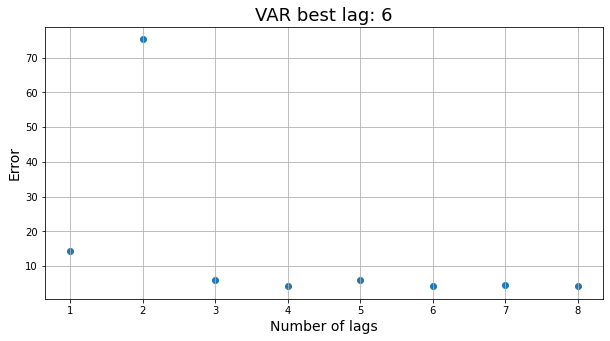

In [8]:
# Plotting and selecting the best lag factor

best_lag = results.index(min(results))+1

fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(range(1,len(results)+1), results)
ax.grid()
ax.set_title('VAR best lag: ' + str(best_lag), fontsize=18)
ax.set_ylabel('Error', fontsize=14)
ax.set_xlabel('Number of lags', fontsize=14)

plt.savefig('Images/lags.png')

In [9]:
# Training out VAR model with the selected lag factor

model = VAR(train)
model_fit = model.fit(maxlags = best_lag, )

# make prediction
yhat = model_fit.forecast(model_fit.y, steps=5)

pred = pd.DataFrame(index=range(0,len(yhat)),columns=[labels])
for j in range(0,len(labels)):
    for i in range(0, 5):
       pred.iloc[i][j] = yhat[i][j]

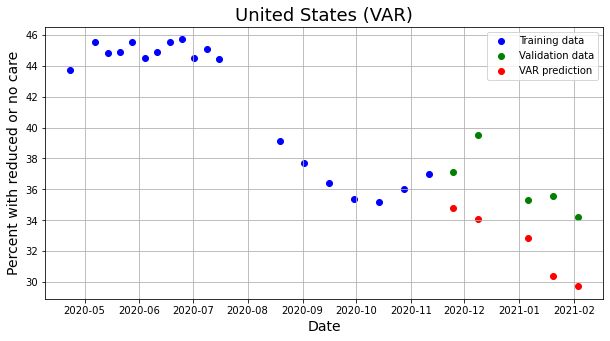

In [11]:
# Plotting modeling results

dates = list((df['Time Period Start Date'].unique()))
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(dates[0:-5], train['United States'], color = 'b', label = 'Training data')
ax.scatter(dates[-5:], val['United States'], color = 'g', label = 'Validation data')
ax.scatter(dates[-5:], pred[['United States']], color = 'r', label = 'VAR prediction')

ax.grid()
ax.set_title('United States' + ' (VAR)', fontsize=18)
ax.set_ylabel('Percent with reduced or no care', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
ax.legend()
plt.savefig('Images/VAR.png')

#### VAR results
The VAR model clearly under predicts our validation data. This was using the best lag varable so we will continue with our analysis.

On thing that is obvious are the gaps in the data, after each one the data shifts dramatically. Our current model doesn't take that into account. For future improvements we could look into taking the gaps into account, possibly by imputing the "missing" data. 

For now we will use the model to predict future values and try to determine when access to care will return to normal. Which, according to the CDC, is around 8%. 

In [12]:
# Modeling future data using the entire dataset available and the best lag previously determined

addLabel = []
steps = 16

model = VAR(dfM[labels + addLabel])
model_fit = model.fit(maxlags = best_lag)

# make prediction
yhat = model_fit.forecast(model_fit.y, steps=steps)

pred = pd.DataFrame(index=range(0,len(yhat)),columns=[labels + addLabel])
for j in range(0,len(labels)+len(addLabel)):
    for i in range(0, steps):
        pred.iloc[i][j] = yhat[i][j]

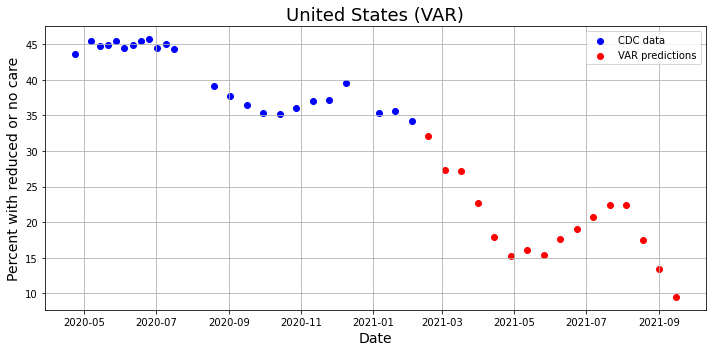

In [13]:
# Plotting future data

# setting the future dates
extDates = []
u = dates[-1]
d = datetime.timedelta(weeks = 2)
for i in range(steps):
    t = u + d
    u = t
    extDates.append(t)

# creating the plot
i = 'United States'
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(dates, data.loc[i]['Value'], color = 'b', label = 'CDC data')
ax.scatter(extDates, list(pred.T.loc[i].values), color='r', label = 'VAR predictions')
ax.grid()
ax.set_title(i + ' (VAR)', fontsize=18)
ax.set_ylabel('Percent with reduced or no care', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
ax.legend()
plt.tight_layout()
plt.savefig('Images/VARpredict.png')

#### VAR future predictions
Despite our models somewhat poor performance against the validation data the future predictions looks pretty reasonable. The model indicates that access to care would return to normal on 10/13/2021. 

#### VAR future predictions vs actual data
The previous analysis was done in April 2021 using data collected up to 02/03/2021. In September 2021 CDC data was recollected to check the model performance. The new data included data up to 6/23/2021 allowing us to check a few months of data against our predictions. 

In [14]:
month = 'JUN'
df = pd.read_csv(f"DATA/DATAFRAME_{month}_accessToCare.csv")
df.loc[:,'Time Period Start Date'] = df['Time Period Start Date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d').date()) 
df.loc[:,'Time Period End Date'] = df['Time Period End Date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d').date()) 

data_aug = df.groupby(['Subgroup', 'Time Period']).mean()

In [15]:
row = []
for i in df.Subgroup.unique():
    row.append(list(data_aug.loc[i].Value))
dfA = pd.DataFrame(row).T
dfA.columns = df.Subgroup.unique()
dfA.head()

,United States,18 - 29 years,30 - 39 years,40 - 49 years,50 - 59 years,60 - 69 years,70 - 79 years,80 years and above,Male,Female,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,43.7,40.8,41.8,45.6,46.0,46.4,42.2,35.6,40.1,47.1,...,45.5,42.9,40.6,43.3,48.5,47.0,47.7,43.7,45.3,39.3
1,45.5,43.4,45.1,46.8,49.5,44.2,41.3,47.8,42.2,48.7,...,41.3,47.2,39.7,39.2,47.1,50.4,50.9,45.6,46.6,44.8
2,44.8,41.0,44.2,45.7,48.7,46.6,41.0,43.7,41.3,48.1,...,38.1,44.6,41.2,37.2,52.5,44.6,48.4,34.9,42.9,48.9
3,44.9,38.5,43.9,47.2,49.8,46.9,41.8,45.0,41.3,48.3,...,39.3,42.8,43.7,41.1,45.2,44.6,43.5,43.0,45.9,46.1
4,45.5,39.6,45.9,47.4,49.9,46.9,42.3,40.3,41.2,49.6,...,41.2,38.0,43.8,43.1,44.3,40.9,47.5,45.7,44.5,45.7


In [16]:
dates_aug = list((df['Time Period Start Date'].unique()))

In [17]:
steps = steps - len(dates_aug[25:])

extDates = []
u = dates_aug[-1]
d = datetime.timedelta(weeks = 2)
for i in range(steps):
    t = u + d
    u = t
    extDates.append(t)

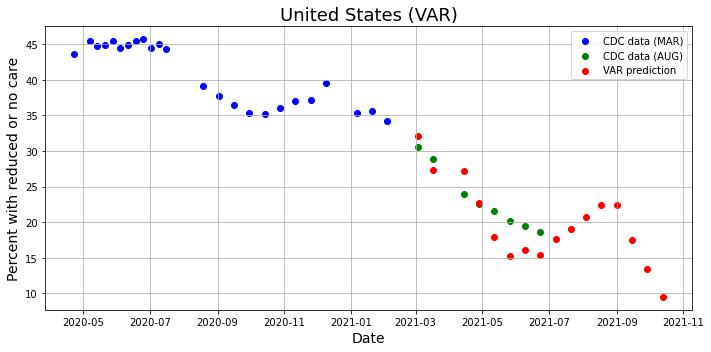

In [18]:
i = 'United States'
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(dates, data.loc[i]['Value'], color = 'b', label = 'CDC data (MAR)')
ax.scatter(dates_aug[25:], data_aug.loc[i]['Value'][25:], color = 'g', label = 'CDC data (AUG)')
ax.scatter(dates_aug[25:], list(pred.T.loc[i].values)[0][:len(dates_aug[25:])], color='r', label = 'VAR prediction')
ax.scatter(extDates, list(pred.T.loc[i].values)[0][len(dates_aug[25:]):], color='r')
ax.grid()
ax.set_title(i + ' (VAR)', fontsize=18)
ax.set_ylabel('Percent with reduced or no care', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
ax.legend()
plt.tight_layout()
plt.savefig('Images/VARpredictvsActual.png')

#### VAR vs actual data results
The predictions from our VAR model seem pretty reasonable, even if it still under predicts the actual data. The CDC data lags behind current events pretty signifcantly, at the time of writing this notebook we have seen the results of the Delta varriant and the hospital closures that have come with it. That could mean access to care was reduced during that time and might track with the peak in the VAR predictions. 

#### Future work
Continuing work on this project their are a few things we could do to imporve the model performance

- Impute missing data
     - Their are a few gaps in the data, currently our VAR model doesn't take that into account which could be skewing the results. Simple imputation of the missing data might improve accuracy
     
- Removing the trend
     - With the original data from Febuary we didn't see much of a trend, however with the data from June we can now see that the data does have a strong downward trend. This could be removed with differencing which could help model performance
     
- Seasonality
     - The VAR predictions, as well as knowledge of the Delta varriant, could indicate a seasonal trend to the data. While we aren't currently seeing this in the CDC data it's something to look out for in future itterations of this project. 